In [84]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import Image
import random
from tqdm import tqdm

In [85]:
import numpy as np

class Environment:
    def __init__(self, environment_rows, environment_columns, ORDER_REWARD, TERMINAL_PENALTY, STEP_PENALTY, START, reward_locs):
        self.environment_rows = environment_rows
        self.environment_columns = environment_columns
        self.ORDER_REWARD = ORDER_REWARD
        self.TERMINAL_PENALTY = TERMINAL_PENALTY
        self.STEP_PENALTY = STEP_PENALTY
        self.START = START
        self.reward_locs = reward_locs
        self.reward_locs.append(START)
        self.NUM_ORDERS = len(reward_locs)
        self.orders_left = self.NUM_ORDERS        

        # Call the build_environment function to initialize rewards
        self.REWARDS_MAP = self.build_environment(reward_locs) # map of rewards that will not be updated, used for plotting
        self.active_rewrads = self.REWARDS_MAP.copy() # copy of rewards map that will be updated as orders are completed
        

    def build_environment(self, reward_locs):
        # Create a 2D numpy array to hold the rewards for each state.
        rewards = np.full((self.environment_rows, self.environment_columns), self.TERMINAL_PENALTY)

        # Define aisle locations (i.e., white squares) for rows 1 through 9
        aisles = {}
        aisles[0] = []
        aisles[1] = [i for i in range(1, 10)]
        aisles[2] = [1, 5, 9]
        aisles[3] = [1, 5, 9]
        aisles[4] = [i for i in range(1, 10)]
        aisles[5] = [1, 5, 9]
        aisles[6] = [i for i in range(1, 10)]
        aisles[7] = [1, 5, 9]
        aisles[8] = [1, 5, 9]
        aisles[9] = [i for i in range(1, 10)]
        aisles[10] = []

        # Set the rewards for all aisle locations (i.e., white squares)
        for row_index in range(0, 11):
            for column_index in aisles[row_index]:
                rewards[row_index, column_index] = self.STEP_PENALTY

        # Set the reward for the packaging area (i.e., the goal) to ORDER_REWARD
        for loc in reward_locs[:-1]:
            rewards[loc[0], loc[1]] = self.ORDER_REWARD
        
        return rewards

    def reset_active_rewards(self):
        self.active_rewrads = self.REWARDS_MAP.copy()
        self.orders_left = self.NUM_ORDERS    
        
    def is_terminal_state(self, current_row_index, current_column_index):
        if self.active_rewrads[current_row_index, current_column_index] == self.TERMINAL_PENALTY:
            return True
        else:
            return False
    
    def is_order_state(self, current_row_index, current_column_index):
        """Returns True if the current state is an order state, False otherwise
        
        Also removes the order from the active rewards map, and updates the number of orders left
        
        """

        if self.active_rewrads[current_row_index, current_column_index] == self.ORDER_REWARD:
            self.active_rewrads[current_row_index, current_column_index] = self.STEP_PENALTY
            self.orders_left -= 1
            #print("Order completed! Orders left: ", self.orders_left)
            if self.orders_left == 1:
                self.active_rewrads[self.START[0], self.START[1]] = self.ORDER_REWARD
            return True
        else:
            return False
    
    
    def get_starting_location(self):
        return self.START[0], self.START[1]
        


In [86]:
#define the shape of the environment (i.e., its states)
environment_rows = 11
environment_columns = 11
ORDER_REWARD = 100
TERMINAL_PENALTY = -100
STEP_PENALTY = -1
START = (1,5)
reward_locs = [(8,2),(2,7),(5,4),(8,7)]


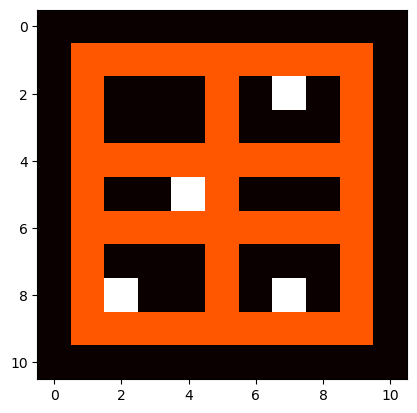

In [87]:
# Initialize the Environment class
env = Environment(environment_rows, environment_columns, ORDER_REWARD, TERMINAL_PENALTY, STEP_PENALTY, START, reward_locs)

# You can access the rewards array using env.rewards
plt.imshow(env.active_rewrads, cmap='hot', interpolation='nearest')


In [88]:
env.is_terminal_state(1,1)

False

In [89]:
import numpy as np
from typing import Any, Type
from tqdm import tqdm

class QLearningAgent:
    def __init__(self, NUM_ORDERS, environment: Type[Environment],environment_rows, environment_columns, actions=['up', 'right', 'down', 'left']):
        self.env = environment
        self.q_values = np.zeros((NUM_ORDERS, environment_rows, environment_columns, 4))
        self.NUM_ORDERS = NUM_ORDERS
        self.environment_rows = environment_rows
        self.environment_columns = environment_columns
        self.actions = actions


    def get_next_action(self, current_row_index, current_column_index, epsilon, order_number):
        if np.random.random() < epsilon:
            return np.argmax(self.q_values[order_number, current_row_index, current_column_index])
        else:
            return np.random.randint(4)

    def get_next_location(self, current_row_index, current_column_index, action_index):
        new_row_index = current_row_index
        new_column_index = current_column_index
        if self.actions[action_index] == 'up' and current_row_index > 0:
            new_row_index -= 1
        elif self.actions[action_index] == 'right' and current_column_index < self.environment_columns - 1:
            new_column_index += 1
        elif self.actions[action_index] == 'down' and current_row_index < self.environment_rows - 1:
            new_row_index += 1
        elif self.actions[action_index] == 'left' and current_column_index > 0:
            new_column_index -= 1
        else:
            raise Exception(f"Invalid action {action_index}")
        return new_row_index, new_column_index
    
    def get_shortest_path(self):
        self.env.reset_active_rewards()
        shortest_path = []
        if self.env.is_terminal_state(self.env.START[0], self.env.START[1]) or self.env.is_order_state(self.env.START[0], self.env.START[1]):
            raise Exception("Cannot find shortest path from terminal state or order state, start from a different location")
        current_row_index, current_column_index = self.env.get_starting_location()
        shortest_path.append([current_row_index, current_column_index])
        while not self.env.is_terminal_state(current_row_index, current_column_index) and self.env.orders_left > 0:
            order_number = self.env.NUM_ORDERS - self.env.orders_left # order number is the number of orders completed so far which is the index of the current order and defines the q_values layer to use
            action_index = self.get_next_action(current_row_index, current_column_index,1.0, order_number)
            current_row_index, current_column_index = self.get_next_location(current_row_index, current_column_index, action_index)
            shortest_path.append([current_row_index, current_column_index])
            self.env.is_order_state(current_row_index, current_column_index)
            
            if len(shortest_path) > 1000:
                print("Infinite loop! Something is wrong")
                break
        return shortest_path
    
    def train(self, num_episodes, epsilon, discount_factor, learning_rate):
        gamma = 1-(1 / (num_episodes/2))
        progress_bar = tqdm(range(num_episodes), desc="Training Progress", unit="Episode")
        zero_order_hit_count = 0
        one_order_hit_count = 0
        episode_rewards_list = []
        for episode in progress_bar:
            self.env.reset_active_rewards()
            episode_rewards_sum = 0
            row_index, column_index = self.env.get_starting_location()
            
            while not self.env.is_terminal_state(row_index, column_index) and self.env.orders_left > 0:
                order_number = self.env.NUM_ORDERS - self.env.orders_left
                action_index = self.get_next_action(row_index, column_index,epsilon, order_number=order_number)
                
                old_row_index, old_column_index = row_index, column_index # store the old row and column indexes
                row_index, column_index = self.get_next_location(row_index, column_index, action_index)
                
                reward = self.env.active_rewrads[row_index, column_index]
                episode_rewards_sum += reward
                
                old_q_value = self.q_values[order_number, old_row_index, old_column_index, action_index]
                temporal_difference = reward + (discount_factor * np.max(self.q_values[order_number, row_index, column_index])) - old_q_value
                new_q_value = old_q_value + (learning_rate * temporal_difference)
                self.q_values[order_number, old_row_index, old_column_index, action_index] = new_q_value
                
                if self.env.is_order_state(row_index, column_index):
                    if self.env.orders_left == 0:
                        zero_order_hit_count += 1
                    elif self.env.orders_left == 1:
                        one_order_hit_count += 1
                
            episode_rewards_list.append(episode_rewards_sum)
            
            learning_rate = max(learning_rate * gamma, 0.01)
            epsilon = min(epsilon * (2-gamma), 0.9)

            progress_bar.set_postfix({"Ord left": self.env.orders_left, "lr": learning_rate, "Eps": epsilon,
                                      "0 Order":zero_order_hit_count, "1 Order":one_order_hit_count})
        
        progress_bar.close()
        return episode_rewards_list
            
        



In [90]:
agent = QLearningAgent(env.NUM_ORDERS, env,env.environment_rows, env.environment_columns)
agent.q_values.shape

(5, 11, 11, 4)

In [91]:
reward_per_episode_list = agent.train(num_episodes=10000, epsilon=0.9, discount_factor=0.9, learning_rate=0.9)

Training Progress: 100%|██████████| 10000/10000 [00:07<00:00, 1303.27Episode/s, Ord left=2, lr=0.122, Eps=0.9, 0 Order=2004, 1 Order=3292]


In [92]:
shortest_path = agent.get_shortest_path()

In [93]:
shortest_path

[[1, 5],
 [1, 6],
 [1, 7],
 [2, 7],
 [1, 7],
 [1, 6],
 [1, 5],
 [2, 5],
 [3, 5],
 [4, 5],
 [5, 5],
 [5, 4],
 [6, 4],
 [6, 3],
 [6, 2],
 [6, 1],
 [7, 1],
 [8, 1],
 [8, 2],
 [9, 2],
 [9, 3],
 [9, 4],
 [9, 5],
 [9, 6],
 [9, 7],
 [8, 7],
 [9, 7],
 [9, 6],
 [9, 5],
 [8, 5],
 [7, 5],
 [6, 5],
 [5, 5],
 [4, 5],
 [3, 5],
 [2, 5],
 [1, 5]]